### The work in this Jupyter Notebook is based on the paper by (Lu et al., 2021) and the paper by (Wang et al., 2021)

We will consider the 1D Poisson equation
$$
-\frac{d^2 u}{d x^2} = f(x), \quad 0 \le x \le 1
$$

Subject to the boundary condtions
$$
u(0) = u(1) = 0
$$

$f(x)$ is the forecing term.

Our goal is to determine the function $u(x)$ for different forcing terms $f(x)$. In other words, we are trying to determine an operator $G$ such that $G:f \rightarrow u$.

The operator $G$ will be approximated by the branch neural network in the case of the DeepOnet model, $G_{\theta} \approx G$. Where $\theta$ represents the paramter of the branch NN.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from random import randint
from math import exp, pi

To trian our model, we need to input different functions to the trunk NN and to generate different functions $f(x)$ we are going to consider the space of polynomials of degree $n$.

The space of polynomial of degree $n$ is defined as the following.
$$
P^n(x) = a_0 + a_1 x + a_2 x^2 + \dots \dots + a_n x^n = \sum_{i=0}^{n} a_i x^i
$$
Where $a_i \in \mathbb{R}$

For our problem we will use $n=3$ and $a_i \in [-1, 1]$.

In [ ]:
# Define the power series class
class PowerSeries:

  def __init__(self, degree):
    self.degree = degree
    self.coefficients = []
    for i in range(degree + 1):
      rand_num = ( randint(-100, 100) / 100 )
      self.coefficients.append(rand_num)

  def poly_coefficients(self):
    return self.coefficients

  def evaluate(self, x):
    y = torch.zeros_like(x)
    x_current = 1
    for a in self.coefficients:
      y = y + a * x_current
      x_current = x_current * x

    return y

####We create a Fully Connected Neural Network

In [ ]:
class FCN(nn.Module):

  def __init__(self, n_input, n_output, n_hidden_layers, n_neuron):
    super().__init__()
    self.n_input = n_input # number of input features
    self.n_output = n_output # number of out features
    self.n_hidden_layers = n_hidden_layers
    self.n_neuron = n_neuron

    #Define the input layer
    self.input_layer = nn.Sequential(
        nn.Linear(self.n_input, self.n_neuron),
        nn.Tanh())

    #Define the hidden layers
    self.hidden_layers = []
    for _ in range(self.n_hidden_layers - 1):
      self.hidden_layers.append(nn.Linear(self.n_neuron, self.n_neuron))
      self.hidden_layers.append(nn.Tanh())

    self.hidden_layers = nn.Sequential(*self.hidden_layers)

    #Define the output layer
    self.output_layer = nn.Linear(self.n_neuron, self.n_output)

  def forward(self, x):
    prediction = self.input_layer(x)
    prediction = self.hidden_layers(prediction)
    prediction = self.output_layer(prediction)
    return prediction

In [ ]:
# Function to initialize the weights of the network
def nn_xavier_init(component):
  if isinstance(component, nn.Linear):
    nn.init.xavier_normal_(component.weight)

In [ ]:
#Define the sensor points
sensors_num = 10
sensors = torch.linspace(0, 1, sensors_num)

#Define the boundary points
x_0 = torch.tensor([[0.0]])
x_f = torch.tensor([[1.0]])
u_0 = torch.tensor([0.0])
u_f = torch.tensor([0.0])

## Branch Netowrk

The following cell defines the input to the branch neural network, which is in our example, 100 functions (forcing term) from the input function space evaluated at 10 sensor points. The input can be represented by the following matrix

$$
branch_{in} =
\begin{pmatrix}
f_1(x_1) & f_1(x_2) & f_1(x_3) & \dots & f_1(x_{10})\\
f_2(x_1) & f_2(x_2) & f_2(x_3) & \dots & f_2(x_{10})\\
\vdots & \vdots & \vdots & \dots & \vdots\\
f_{100}(x_1) & f_{100}(x_2) & f_{100}(x_3) & \dots & f_{100}(x_{10})
\end{pmatrix}
$$

<br></br>
The output will be a representation of the approximated function
<br></br>

$$
branch_{out} = \begin{pmatrix}
u^{(1)}_1 & u^{(1)}_2 & u^{(1)}_3 & \dots & u^{(1)}_m\\
u^{(2)}_1 & u^{(2)}_2 & u^{(2)}_3 & \dots & u^{(2)}_m\\
\vdots & \vdots & \vdots & \dots & \vdots\\
u^{(100)}_1 & u^{(100)}_2 & u^{(100)}_3 & \dots & u^{(100)}_m\\
\end{pmatrix}
$$

<br></br>
for each $f_i(x)$ where $i=1, 2, 3, \dots, 100$

<br></br>
$$
G_{\theta}:
\begin{bmatrix}
f_i(x_1) & f_i(x_2) & f_i(x_3) & \dots & f_i(x_{10})
\end{bmatrix}
\rightarrow
\begin{bmatrix}
u^{(i)}_1 & u^{(i)}_2 & u^{(i)}_3 & \dots & u^{(i)}_m
\end{bmatrix}
$$

<br></br>
$$
u_i(x) =
\begin{bmatrix}
u^{(i)}_1 & u^{(i)}_2 & u^{(i)}_3 & \dots & u^{(i)}_m
\end{bmatrix}
$$

<br></br>
$u_i(x)$ is not yet evaluated at any point. For the evaluation, we will use the output of the trunk neural network.

In [ ]:
#Define the branch input, which are the fs functions
num_fun = 100
fs = []
f_sensors = [] #functions evluated at sensors
for i in range(num_fun):
  fun = PowerSeries(3) #polynomials of degree 3
  fs.append(fun)
  f_sensors.append(fun.evaluate(sensors))

f_sensors = torch.stack(f_sensors)

## Trunk Network

The input to the trunk neural network is points where we want to evalute the target function $u(x)$ at and we represneted by the following column vector

$$
trunk_{in} =
\begin{pmatrix}
p_1 \\
p_2 \\
\vdots \\
p_{100}
\end{pmatrix}
$$

**Note**: I used $p$ instead of $x$ so there is no confusion with between these points and the sensor points.
<br></br>
since $0 \le x \le 1$, then $0 \le p_j \le 1$ for $j=1, 2, 3, \dots 100$

The tunk neural network will map each point to a higher dimensions and in this case we require that the output dimensions of the branch and the trunk networks must be the same. Therefore, the output the trunk neural network is the following

<br></br>
$$
trunk_{out} = \begin{pmatrix}
b^{(1)}_1 & b^{(1)}_2 & b^{(1)}_3 & \dots & b^{(1)}_m\\
b^{(2)}_1 & b^{(2)}_2 & b^{(2)}_3 & \dots & b^{(2)}_m\\
\vdots & \vdots & \vdots & \dots & \vdots \\
b^{(100)}_1 & b^{(100)}_2 & b^{(100)}_3 & \dots & b^{(100)}_m\\
\end{pmatrix}
$$

<br></br>
For each $p_j$ where $j=1, 2, 3, \dots, 100$,
<br></br>
$$
\mathbf{NN}_{\text{trunk}}(p_j) = \begin{bmatrix}
b^{(j)}_1 & b^{(j)}_2 & b^{(j)}_3 & \dots & b^{(j)}_m
\end{bmatrix}
$$


In [ ]:
# Define the trunk input
num_domain = 100
trunk_in = torch.linspace(0, 1, num_domain).unsqueeze(-1).requires_grad_(True)

## Evaluation

To evaluate the output $u_i$ at the trunk points, we take the dot product of the branch output and the trunk output and that is why we require the output dimensions of both netowrks to be the same. For example, to evaluate $G(f_i)$ at $p_j$ we perform the following operation

$$
G_{\theta}(f_i)(p_j) = u_i(p_j) = \begin{bmatrix}
u^{(i)}_1 & u^{(i)}_2 & u^{(i)}_3 & \dots & u^{(i)}_m
\end{bmatrix} \cdot \begin{bmatrix}
b^{(j)}_1 & b^{(j)}_2 & b^{(j)}_3 & \dots & b^{(j)}_m
\end{bmatrix}
= \sum_{n=1}^{m} u^{(i)}_n b^{(j)}_n
$$

## Note

In the following cell, we are going to evaluate the functions that have defined as the input to the branch NN at the trunk input points.

**Note:** We have evaluted these functions earlier at the sensor points, but this time we evaluating them at the trunk input points since we are trying to cpmpute the loss due the ODE; That is the following if we consider the mean square loss function

$$
\mathcal{L}_{ODE} = \frac{1}{m} \sum_{j=1}^{m}
\left(
-\frac{d^2 G_{\theta}(f)(p_j)}{dp^2} - f(p_j)
\right)^2_{p=x}
$$

Where $G_{\theta}(f)=u_{\theta}$ and $p_j$ is an input point to the trunk NN.

In [ ]:
f_x = []
x_eval = trunk_in.squeeze().clone().detach()
for fun in fs:
  f_x.append(fun.evaluate(x_eval))

f_x = torch.stack(f_x)

For the purpose of demonstration we are going to use only 1 hidden layers and 32 hidden units for bothe networks. Also, we are going to use LBFGS optimizer since it provides a faster convergence.

In [ ]:
#Define the branch and the trunk nets
output_features = 32
branch = FCN(sensors_num, output_features, n_hidden_layers=1, n_neuron=32)
trunk = FCN(1, output_features, n_hidden_layers=1, n_neuron=32)

#Initialize the nets
branch.apply(nn_xavier_init)
trunk.apply(nn_xavier_init)

#Combine the parameter of the two NNs.
params = list(branch.parameters()) + list(trunk.parameters())
optimizer = optim.LBFGS(params, max_iter=1000)

In [ ]:
epochs = 50
branch.train()
trunk.train()

for epoch in range(1, epochs+1):

  def closure():
    optimizer.zero_grad()

    #evaluation points points (trunk output)
    output_sensors = trunk(trunk_in)

    #u_approx = G(f)
    G_f = branch(f_sensors)

    #u_aprrox evaluated at output sensors G(f)(output_sensors)
    G_f_u = torch.tensordot(G_f, output_sensors, dims=([1],[1]))

    # Compute the derivatives
    d2Gdx2 = []
    for i in range(len(G_f_u)):
      u = G_f_u[i]
      dudx = torch.autograd.grad(u, trunk_in, torch.ones_like(u), create_graph=True)[0]
      d2udx2 = torch.autograd.grad(dudx, trunk_in, torch.ones_like(dudx), create_graph=True)[0]
      d2Gdx2.append( d2udx2 )

    # Compute the pde losses
    d2Gdx2 = torch.stack(d2Gdx2).squeeze().requires_grad_(True)
    pde_loss = torch.mean( (-d2Gdx2 - f_x)**2 )


    #Left and right boundary
    u_0 = trunk(x_0)
    u_f = trunk(x_f)

    G_f_u_0 = torch.tensordot(G_f, u_0, dims=([1], [1]))
    G_f_u_f = torch.tensordot(G_f, u_f, dims=([1],[1]))

    #boundary losses
    left_boundary_loss = torch.mean(G_f_u_0 ** 2)
    right_boundary_loss = torch.mean(G_f_u_f ** 2)

    #total loss
    loss = left_boundary_loss + pde_loss + right_boundary_loss

    loss.backward()
    return loss

  loss = closure()
  optimizer.step(closure)

  if epoch % 10 == 0:
    print(loss.item())


3.969944009440951e-05
3.759008177439682e-05
3.759008177439682e-05
3.759008177439682e-05
3.759008177439682e-05


## Testing the model

We will try to test the model using functions from the input function space.

In [ ]:
def test_model(forcing_term: "function", exact_sol:"function"):
  x_sensors = torch.linspace(0, 1, sensors_num)
  x_axis = torch.linspace(0, 1, 100)
  u_exact = exact_sol(x_axis)

  #evaluation mode
  branch.eval()
  trunk.eval()
  with torch.inference_mode():
    branch_in = forcing_term(x_sensors).unsqueeze(0)
    branch_out = branch(branch_in)
    trunk_out = trunk(x_axis.unsqueeze(-1))
    u_approx = torch.tensordot(branch_out, trunk_out, dims=([1], [1])).squeeze()
    difference = abs(u_exact - u_approx)
    global_error = max(difference)

  #plot the approximation and the exact
  fig = plt.figure(tight_layout=True, dpi=100, figsize=(9, 4))
  ax1 = fig.add_subplot(121)
  ax1.set_title("DeepOnet approximation & exact solution")
  ax1.set_xlabel("x")
  ax1.set_ylabel("u")
  ax1.plot(x_axis, u_exact, label="Exact")
  ax1.plot(x_axis, u_approx, color=((0, 0, 0, 1)), linestyle="--", label="approximation")
  ax1.legend()

  #plot error
  ax2 = fig.add_subplot(122)
  ax2.set_title(f"Error (max = {global_error:.6f})")
  ax2.set_xlabel("x")
  ax2.set_ylabel("difference")
  ax2.plot(x_axis, difference, color=((0.9, 0.3, 0.0)))

  plt.show()
  return u_approx

# Testing using functions inside the space

## Case 1:

We are going to implement a very easy case, which is $f(x) = -1$.
The eaxt solution is $u(x) = \frac{1}{2} \left( x^2 - x\right)$

In [ ]:
def f1_test(x):
  return -torch.ones(len(x))

def exact1(x):
  return 0.5 * ( x**2 - x)

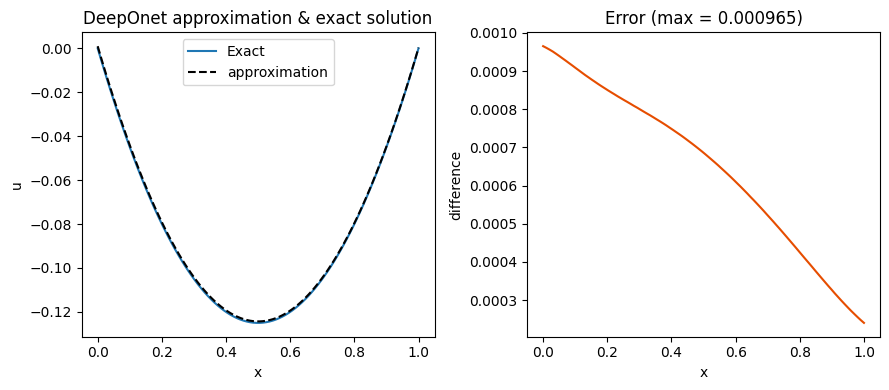

In [ ]:
u1_approx = test_model(f1_test, exact1)

## Case 2:

We going to consider a ploynomial of degree 2.
$$
f(x) = x + 3x^2
$$

The exact solution is
$$
u(x) = -\frac{1}{6} x^3 - \frac{1}{4} x^4 + \frac{10}{24} x
$$

In [ ]:
def f2_test(x):
  return (x + 3 * x**2)

def exact2(x):
  return (-1/6) * x**3 - (1/4) * x**4 + (10/24) * x

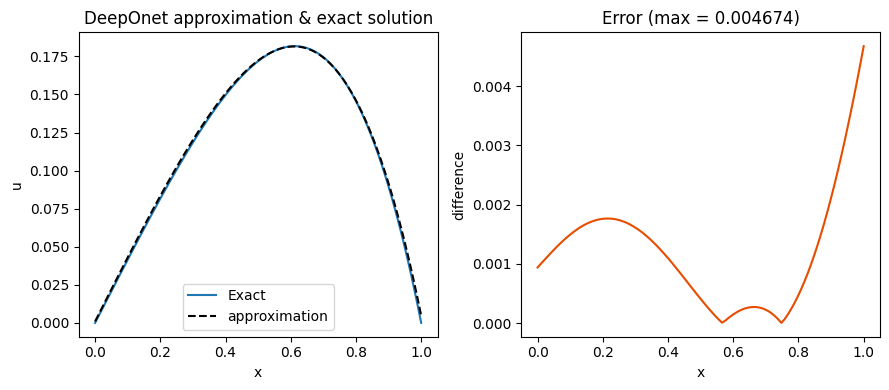

In [ ]:
u2_approx = test_model(f2_test, exact2)

# Testing using out of space functions

## Case 1:
$$
f(x) = e^x
$$

With exact solution

$$
u(x) = - e^x + xe - x + 1
$$

In [ ]:
def f3_test(x):
  return torch.exp(x)

def exact3(x):
  return -torch.exp(x) + x * exp(1) - x + 1

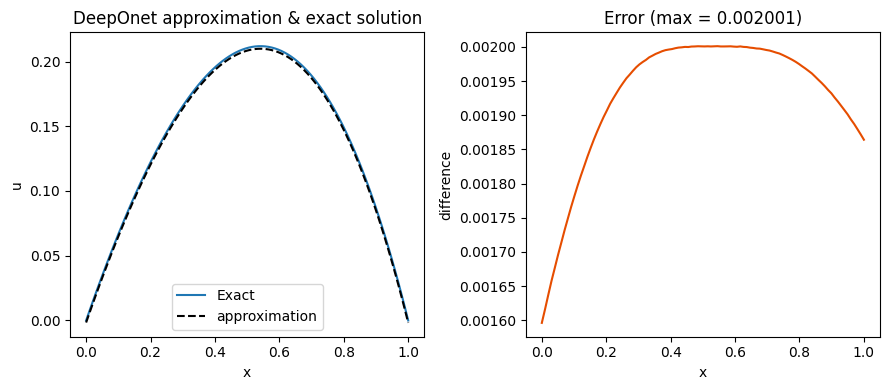

In [ ]:
u3_apprx = test_model(f3_test, exact3)

## Case 2:

$$
f(x) = sin(\pi x) - cos(\pi x)
$$

The exact solution is
$$
u(x) = \frac{1}{\pi^2}
\big[\; sin(\pi x) - cos(\pi x)  - 2x + 1 \; \big]
$$

In [ ]:
def f4_test(x):
  return torch.sin(pi * x) - torch.cos(pi * x)

def u4_eaxt(x):
  return (1/pi**2) * (f4_test(x) - 2 * x + 1)

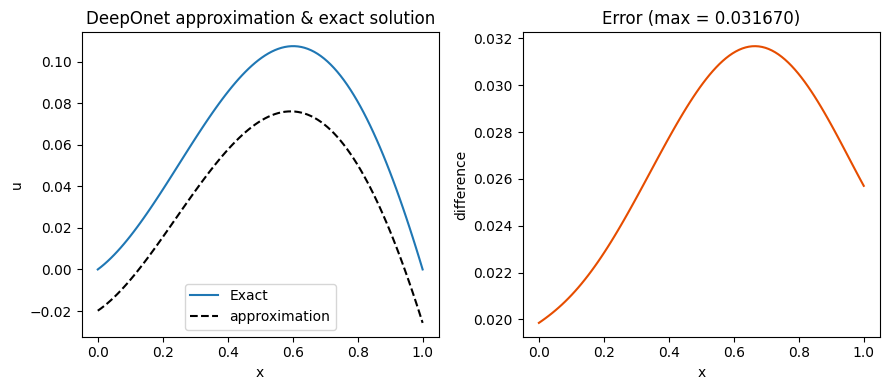

In [ ]:
u4_approx = test_model(f4_test, u4_eaxt)

# References

[1] Lu, L., Jin, P., Pang, G., Zhang, Z., & Karniadakis, G. E. (2021). Learning nonlinear operators via DeepONet based on the universal approximation theorem of operators. Nature machine intelligence, 3(3), 218-229.

[2] Wang, S., Wang, H., & Perdikaris, P. (2021). Learning the solution operator of parametric partial differential equations with physics-informed DeepONets. Science advances, 7(40), eabi8605.